<a href="https://colab.research.google.com/github/tamnhu2913/FakeFace-Detection/blob/main/Train_Face_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall torch torchaudio torchvision -y
!pip install torch==2.5.0+cu118 torchvision==0.20.0+cu118 torchaudio==2.5.0+cu118 --index-url https://download.pytorch.org/whl/cu118
!pip install albumentations

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 92.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 89.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 91.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 112.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
test_path = '/content/drive/MyDrive/RealFace Detector.v6i.tensorflow/test'
train_path = '/content/drive/MyDrive/RealFace Detector.v6i.tensorflow/train'
val_path = '/content/drive/MyDrive/RealFace Detector.v6i.tensorflow/valid'

Mounted at /content/drive


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

In [ ]:
def get_transform(size):
  height, width = size
  transform = A.Compose([
    A.Resize(height = height, width = width),
    A.HorizontalFlip(p=0.4),
    A.RandomBrightnessContrast(p=0.3, brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1)),
    # A.GaussNoise(p=0.3),
    A.ToFloat(max_value=255.0),
    A.pytorch.ToTensorV2()],
    bbox_params= A.BboxParams(format = 'pascal_voc', label_fields=['labels'])
    )
  return transform

class MyDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.transform = transform
    self.dataframe = pd.read_csv(os.path.join(path, '_annotations.csv'))
    self.filename = self.dataframe['filename'].unique()
    self.classes = {'real': 1, 'fake': 2}

  def __len__(self):
    return len(self.filename)

  def __str__(self):
    return f"Number of image: {len(self.filename)}, Total of bounding box: {len(self.dataframe)}"

  def __getitem__(self, index):
    name_image = self.filename[index]
    image_path = os.path.join(self.path, name_image)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    idx = self.dataframe['filename'] == name_image
    size = self.dataframe[idx][['height', 'width']].values
    bndbox = self.dataframe[idx][['xmin', 'ymin', 'xmax', 'ymax']].values
    label = self.dataframe[idx][['class']].values
    label = [self.classes[l[0]] for l in label]
    if self.transform:
      transformed = self.transform(image = image, bboxes = bndbox, labels = label)
      image = transformed['image']
      bndbox = transformed['bboxes']
      label = transformed['labels']
    target = {
        'boxes': torch.tensor(bndbox, dtype = torch.float32),
        'labels': torch.tensor(label, dtype = torch.int64)
    }
    return image, target, size #image: shape (C, H, W)

In [ ]:
def convert_image(image, size):
  H, W = size
  image = image.permute(1, 2, 0).cpu().numpy()
  image = cv2.resize(image, (W,H))
  image = (image * 255.0).astype(np.uint8)
  return image

def plot_box_label(image, bounding_boxes, labels, colors = ((0, 255, 0), (255, 0, 0))):
  for box, label in zip(bounding_boxes, labels):
    lab = 'real' if label == 1 else 'fake'
    color = colors[0] if label == 1 else colors[1]
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 8)
    x = np.max([5, box[0] - 10])
    y = np.max([0, box[1] - 5])
    cv2.putText(image, str(lab), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)

def plot_img(image, size, target = None, pred = None):
  _, new_H, new_W = image.shape
  image = convert_image(image, size)
  scale_x = size[1] / new_W
  scale_y = size[0] / new_H
  if target:
    bndbox = target['boxes'].numpy() * [scale_x, scale_y, scale_x, scale_y]
    label = target['labels'].numpy()
    plot_box_label(image, bndbox, label)
  if pred:
    idx = torch.where(pred['scores']>0.7)[0]
    bndbox = pred['boxes'][idx].cpu().numpy()  * [scale_x, scale_y, scale_x, scale_y]
    label = pred['labels'][idx].cpu().numpy()
    plot_box_label(image, bndbox, label, colors=((0, 255, 255), (255, 255, 0)))
  plt.figure(figsize=(5,5))
  plt.imshow(image)

In [ ]:
def get_model(num_classes):
  model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

def train_per_epoch(model, optimizer, data_loader, device):
  model.train()
  train_loss = []
  for images, targets, _ in data_loader:
    images = [image.to(device) for image in images]
    targets = [{key: value.to(device) for key, value in target.items()} for target in targets]

    # Forward step: Tính loss từ mô hình
    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    # Backward step: Cập nhật gradient và tối ưu hóa
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    train_loss.append(losses.item())

    if torch.isnan(losses):
      print('Loss is nan')
      print('loss dict:', loss_dict)
      print('Targets:', targets)
      exit()

  train_loss = np.mean(train_loss)
  return train_loss

def mean_average_precision(detection_info):
    """
    input:
      detection_info (dictionary): key is number of class,
      [number of true boxes, score of predicted boxes, iou of predicted boxes]
    output:
      mAP: mean average precision
    """
    AP = []
    for clss in detection_info.keys():
      IOU = detection_info[clss][2]  # IOU của các bounding box dự đoán
      device = IOU.device  # Lấy device từ IOU

      # Chuyển detection_info[clss][0] (số box thật) thành tensor trên device
      num_true_boxes = detection_info[clss][0].float().to(device)

      TP = (IOU > 0.5).int()  # True positive
      FP = 1 - TP  # False positive

      csTP = torch.cumsum(TP, dim=0)  # Cumulative sum of True positive
      csFP = torch.cumsum(FP, dim=0)  # Cumulative sum of False positive

      recalls = csTP / num_true_boxes  # Đảm bảo num_true_boxes là tensor trên cùng device
      precisions = csTP / (csTP + csFP)

      # Chuyển tensor mặc định ở CPU sang `device`
      recalls = torch.cat((torch.tensor([0.0], device=device), recalls))
      precisions = torch.cat((torch.tensor([1.0], device=device), precisions))

      AP.append(torch.trapz(precisions, recalls))

    mAP = sum(AP) / len(AP) if len(AP) > 0 else torch.tensor(0.0, device=device)  # Tránh lỗi chia cho 0
    return mAP


def compute_map(model, device, classes, dataloader, threshold_scores=0.5):
  """
  Compute mean Average Precision (mAP) on the validation set or return predictions if it's a test set.

  Args:
      model (torch.nn.Module): The Faster R-CNN model or a similar object detection model.
      dataloader (DataLoader): DataLoader containing validation or test data.
      classes (list): List of class labels to compute mAP for.
      device (torch.device): Device to run the model on ('cuda' or 'cpu').
      is_test (bool): If True, returns model predictions instead of computing mAP.

  Returns:
      float: mAP if not a test set, or a list of model predictions if it's a test set.
  """
  detection_infor = {key: [torch.tensor(0, device=device),
                           torch.tensor([], device=device),
                           torch.tensor([], device=device)] for key in classes}
  model.eval()
  with torch.no_grad():
    for batch in dataloader:
      images, targets, _ = batch
      images = [image.to(device) for image in images]
      output = model(images)

      for true, pred in zip(targets, output):
        for i in classes:
          idx1 = torch.where(true['labels'] == i)[0]
          idx2 = torch.where((pred['labels'] == i) & (pred['scores'] > threshold_scores))[0]
          detection_infor[i][0] += len(idx1)
          if len(idx2) > 0:
            if len(idx1) == 0:
              iou = torch.zeros(len(idx2), device=device)
            else:
              iou, _ = torch.max(
                torchvision.ops.box_iou(pred['boxes'][idx2].to(device), true['boxes'][idx1].to(device)), axis=1)
              iou = iou.to(device)

            detection_infor[i][1] = torch.cat((detection_infor[i][1], pred['scores'][idx2].to(device)))
            detection_infor[i][2] = torch.cat((detection_infor[i][2], iou))
  return mean_average_precision(detection_infor)

lenght of test data: 28
Number of image: 28, Total of bounding box: 51


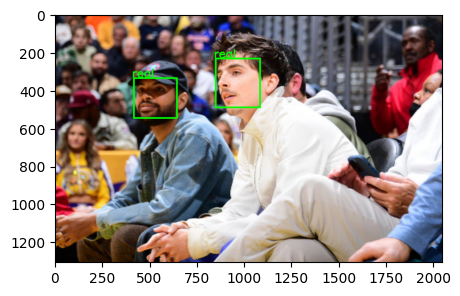

In [ ]:
dataset = MyDataset(test_path, transform = get_transform((500, 500)))
print('lenght of test data:', len(dataset))
print(dataset)
image, target, size = dataset.__getitem__(5)
plot_img(image, size[0], target = target)

lenght of test data: 433
Number of image: 433, Total of bounding box: 915


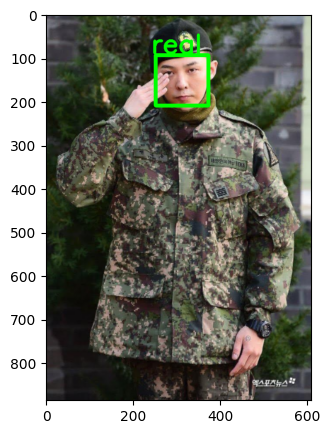

In [ ]:
dataset = MyDataset(train_path, transform = get_transform((500, 500)))
print('lenght of test data:', len(dataset))
print(dataset)
image, target, size = dataset.__getitem__(40)
plot_img(image, size[0], target = target)

lenght of test data: 175
Number of image: 175, Total of bounding box: 300


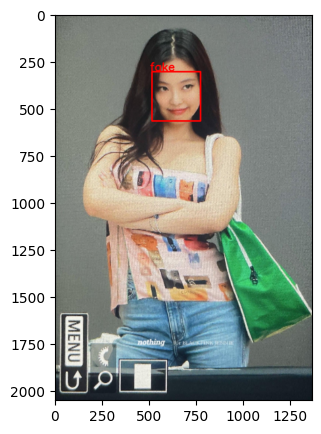

In [ ]:
dataset = MyDataset(val_path, transform = get_transform((500, 500)))
print('lenght of test data:', len(dataset))
print(dataset)
image, target, size = dataset.__getitem__(100)
plot_img(image, size[0], target = target)

In [ ]:
size = (500,500)
train_set = MyDataset(train_path, transform= get_transform(size))
val_set = MyDataset(val_path, transform= get_transform(size))

train_loader = DataLoader(train_set, batch_size=3, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)))
val_loader = DataLoader(val_set, batch_size=3, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
best_mAP = 0
best_loss = 0

epochs = 30
num = 3
model = get_model(num)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum= 0.9, weight_decay=0.001)

cuda:0


In [ ]:
for epoch in range(epochs):
    start_time = time.time()
    train_loss = train_per_epoch(model, optimizer, train_loader, device)
    mAP = compute_map(model, device, [1,2], val_loader)
    if mAP > best_mAP:
        best_mAP = mAP
        best_loss = train_loss
        torch.save(model.state_dict(), './model.pth')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f'time: {elapsed_time // 60:.0f}m:{elapsed_time % 60:.0f}s')
    print(f'Epoch: {epoch + 1}, loss: {train_loss:.4f}, mAP: {mAP:.4f}')
    if best_mAP > 0.65 and train_loss < 0.105:
      break
print('Best mAP:', best_mAP, 'Loss train:', best_loss)

time: 1m:53s
Epoch: 1, loss: 0.3422, mAP: 0.2785
time: 1m:54s
Epoch: 2, loss: 0.2343, mAP: 0.2727
time: 1m:54s
Epoch: 3, loss: 0.2055, mAP: 0.3355
time: 1m:54s
Epoch: 4, loss: 0.1827, mAP: 0.4905
time: 1m:54s
Epoch: 5, loss: 0.1676, mAP: 0.5821
time: 1m:53s
Epoch: 6, loss: 0.1526, mAP: 0.3569
time: 1m:54s
Epoch: 7, loss: 0.1468, mAP: 0.5214
time: 1m:53s
Epoch: 8, loss: 0.1333, mAP: 0.4733
time: 1m:53s
Epoch: 9, loss: 0.1241, mAP: 0.5781
time: 1m:53s
Epoch: 10, loss: 0.1142, mAP: 0.5243
time: 1m:54s
Epoch: 11, loss: 0.1073, mAP: 0.6380
time: 1m:54s
Epoch: 12, loss: 0.1053, mAP: 0.6720
time: 1m:53s
Epoch: 13, loss: 0.0998, mAP: 0.5843
Best mAP: tensor(0.6720, device='cuda:0') Loss train: 0.10529482463567422
